In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
import lightgbm as lgb


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\Sergey\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
 def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
   
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

# def evaluate_preds(true_values, pred_values, save=False):
#     """Оценка качества модели и график preds vs true"""
    
#     print("R2:\t" + str(round(r2(true_values, pred_values), 3))
#          )
    
#     plt.figure(figsize=(8,8))
    
#     sns.scatterplot(x=pred_values, y=true_values)
#     plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
#     plt.xlabel('Predicted values')
#     plt.ylabel('True values')
#     plt.title('True vs Predicted values')
    
#     if save == True:
#         plt.savefig(REPORTS_FILE_PATH + 'report.png')
#     plt.show()

### Пути к директориям и файлам

In [5]:
TRAIN_DATASET_PATH = 'project_task/train.csv' # y_train, y_valid
TEST_DATASET_PATH = 'project_task/test.csv'

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [8]:
train_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [9]:
# test_id = test_df["Id"]
# pred_df = pd.DataFrame()
# pred_df["Id"] = test_id
# pred_df["Price"] = np.random.randint(0, 1e6, size=test_id.shape[0])
# assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

# pred_df.to_csv("./predictions_.csv", index=False)

### Разбиение на train и valid

In [10]:
feature_names = ['Id','DistrictId','Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Price']

#new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict']

target_name = 'Price'

In [11]:
X = train_df[feature_names]
y = train_df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21) # test_size=0.33 ????
X_valid = X_valid.drop('Price', axis=1)

In [12]:
X_train.shape

(6700, 20)

In [13]:
X_valid.shape

(3300, 19)

In [14]:
X_valid.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,3300.000000,3300.000000,3300.000000,3300.000000,2627.000000,3300.000000,3300.000000,3300.000000,3.300000e+03,3300.000000,3300.000000,3300.000000,3300.000000,1721.000000,3300.000000,3300.000000
mean,8302.300303,50.249091,1.906667,56.791432,36.767259,5.938788,8.591515,12.532121,8.060947e+03,0.119095,24.720303,5390.651818,8.214242,1127.380012,1.292424,4.248182
std,4870.111395,43.751064,0.885923,22.205235,19.939261,5.372672,5.283401,6.720317,3.490262e+05,0.117867,17.682859,4065.624981,24.063203,1022.123686,1.457783,4.794717
min,6.000000,0.000000,0.000000,1.136859,1.049867,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,4023.000000,19.000000,1.000000,41.726780,22.860266,1.000000,4.000000,9.000000,1.974000e+03,0.020741,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,8286.500000,36.000000,2.000000,53.300742,33.169951,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5273.000000,2.000000,900.000000,1.000000,3.000000
75%,12479.500000,74.000000,3.000000,66.310626,45.754902,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7425.000000,5.000000,1450.000000,2.000000,6.000000
max,16781.000000,208.000000,19.000000,604.705972,410.639749,84.000000,37.000000,99.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


In [15]:
X_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [16]:
X_train.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

In [17]:
X_train['Id'] = X_train['Id'].astype(str)
X_train['DistrictId'] = X_train['DistrictId'].astype(str)

In [18]:
df_num_features = X_train.select_dtypes(include=['float64'])
df_num_features.head(n=2)
df_num_features.hist(figsize=(16,16), bins=20, grid =True);


,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Healthcare_1,Price
9239,1.0,39.45819,21.630224,8.0,17.0,0.0509,30.0,130416.073182
6930,1.0,57.08864,23.298211,10.0,30.0,0.0000,2672.0,298237.106464


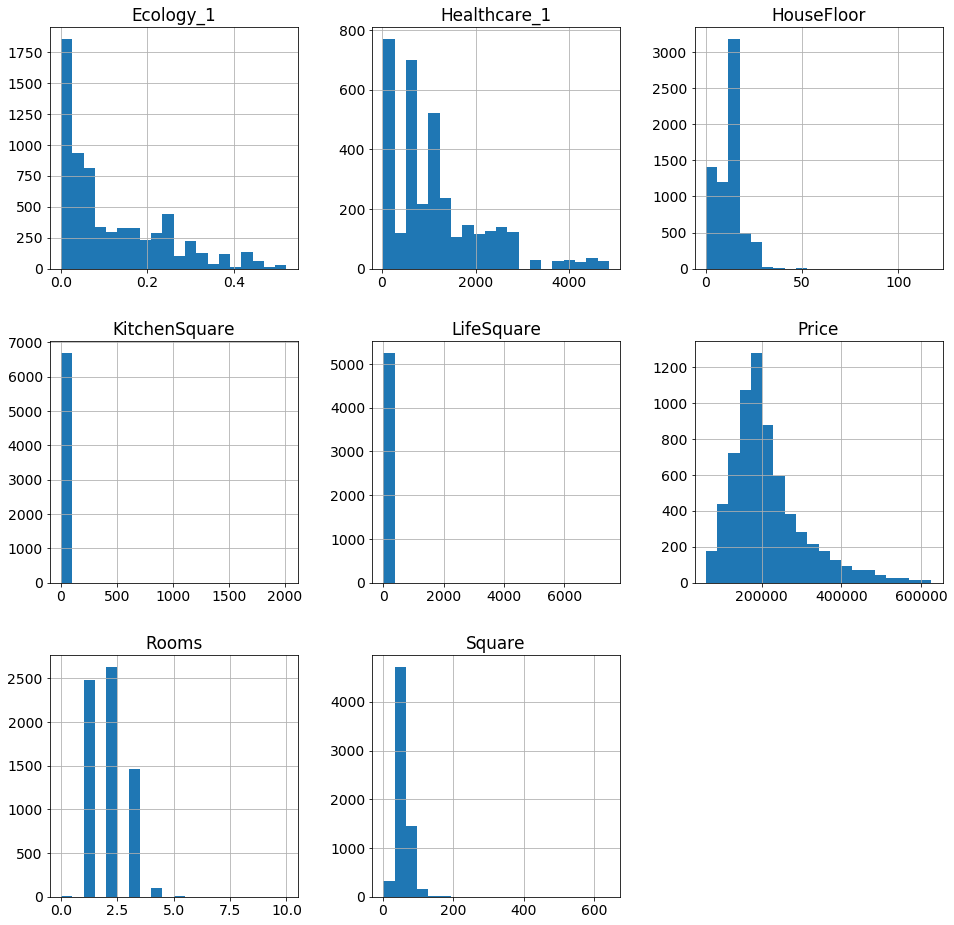

In [19]:
df_num_features.hist(figsize=(16,16), bins=20, grid =True);

## Обзор данных

### Целевая переменная

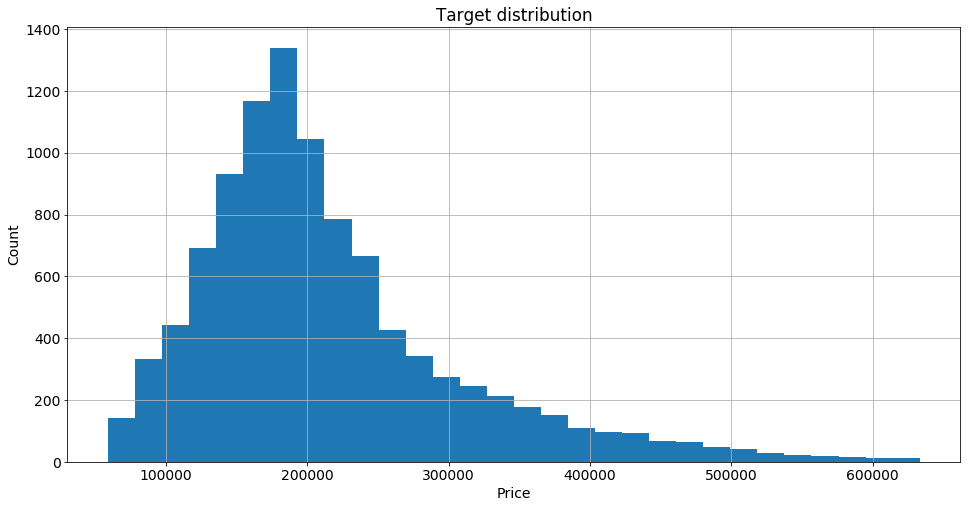

In [21]:
plt.figure(figsize = (16, 8))

#X_train['Price'].hist(bins=30)
train_df[target_name].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

### Количественные переменные

In [22]:
X_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,6700.000000,6700.000000,5260.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,3481.000000,6700.000000,6700.000000,6700.000000
mean,1.882537,56.081497,37.415591,6.438060,8.494776,12.647463,1985.154776,0.118740,24.670597,5333.197463,7.952985,1150.579718,1.332836,4.222985,213872.986633
std,0.815633,20.468093,104.661936,34.688095,5.220311,6.803397,40.872731,0.119600,17.459441,3977.675264,23.718438,1021.277009,1.510859,4.812391,92638.972848
min,0.000000,1.988943,0.370619,0.000000,1.000000,0.000000,1912.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.798893,22.711308,1.000000,4.000000,9.000000,1973.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153994.680334
50%,2.000000,52.083642,32.505331,6.000000,7.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192817.509808
75%,2.000000,65.790145,44.768302,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249080.956886
max,10.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,4968.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,625820.041178


In [23]:
X_valid.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,3300.000000,3300.000000,3300.000000,3300.000000,2627.000000,3300.000000,3300.000000,3300.000000,3.300000e+03,3300.000000,3300.000000,3300.000000,3300.000000,1721.000000,3300.000000,3300.000000
mean,8302.300303,50.249091,1.906667,56.791432,36.767259,5.938788,8.591515,12.532121,8.060947e+03,0.119095,24.720303,5390.651818,8.214242,1127.380012,1.292424,4.248182
std,4870.111395,43.751064,0.885923,22.205235,19.939261,5.372672,5.283401,6.720317,3.490262e+05,0.117867,17.682859,4065.624981,24.063203,1022.123686,1.457783,4.794717
min,6.000000,0.000000,0.000000,1.136859,1.049867,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,4023.000000,19.000000,1.000000,41.726780,22.860266,1.000000,4.000000,9.000000,1.974000e+03,0.020741,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,8286.500000,36.000000,2.000000,53.300742,33.169951,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5273.000000,2.000000,900.000000,1.000000,3.000000
75%,12479.500000,74.000000,3.000000,66.310626,45.754902,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7425.000000,5.000000,1450.000000,2.000000,6.000000
max,16781.000000,208.000000,19.000000,604.705972,410.639749,84.000000,37.000000,99.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


### Категориальные признаки

In [24]:
def cat_features(df):
    cat_colnames = df.select_dtypes(include='object').columns.tolist()
    for cat_colname in cat_colnames[2:]:
        print(str(cat_colname) + '\n\n' + str(X_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')
    
    
    return df


### Обработка выбросов

In [25]:
def df_fix(df):
    df.loc[df['Rooms'].isin([0, 10, 19]), 'Rooms'] = df['Rooms'].median()
    df.loc[df['Square'] > df['Square'].quantile(.99), 'Square'] = df['Square'].median()  
    df.loc[df['Square'] < df['Square'].quantile(.01), 'Square'] = df['Square'].median()
    df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df['LifeSquare'].median()
    df.loc[df['LifeSquare'] > df['LifeSquare'].quantile(.99), 'LifeSquare'] = df['LifeSquare'].median()
    df.loc[df ['LifeSquare'] < df['LifeSquare'].quantile(.01), 'LifeSquare'] = df['LifeSquare'].median()
    df.loc[X_train['KitchenSquare'].isnull(), 'KitchenSquare'] = df['KitchenSquare'].median
    df.loc[X_train['KitchenSquare'] < 3, 'KitchenSquare'] = 3
    df.loc[X_train['KitchenSquare'] > 25, 'KitchenSquare'] = df['KitchenSquare'].median()

    df.loc[df['Square']< df["KitchenSquare"] + df["LifeSquare"], 'Square'] =  df["KitchenSquare"] + df["LifeSquare"]
    df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()
    floor_outliers = df[X_train['Floor'] > df['HouseFloor']].index
    df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
    df.loc[X_train['HouseYear'] > 2020, 'HouseYear'] = 2020
    df.loc[X_train['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
    
    return df
    

In [26]:
X_train['Rooms'].value_counts()

2.0     2633
1.0     2485
3.0     1467
4.0       95
5.0       13
0.0        5
10.0       1
6.0        1
Name: Rooms, dtype: int64

In [27]:
X_train['Rooms'].shape

(6700,)

In [28]:
X_train['Rooms'].median()

2.0

In [29]:
df_fix(X_train)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9239,14100,93,1.0,39.4582,21.630224,8,9,17.0,1985,0.050900,B,B,43,10621,1,30.0,2,3,B,130416.073182
6930,13906,26,1.0,57.0886,23.298211,10,4,30.0,2014,0.000000,B,B,36,6714,2,2672.0,0,2,B,298237.106464
8136,715,44,1.0,32.7776,22.448450,5,8,9.0,1967,0.036122,B,B,24,4378,0,1036.0,1,1,B,170455.930747
3424,3518,37,1.0,37.7521,20.140014,10,6,15.0,1976,0.127812,B,B,28,7287,5,320.0,1,3,B,167876.802185
6518,10941,23,1.0,35.5053,32.505331,3,2,12.0,1977,0.034656,B,B,0,168,0,900.0,0,0,B,76228.918314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,7845,8,1.0,38.4764,23.803304,9,10,14.0,1971,0.092291,B,B,21,4346,2,165.0,1,2,B,177869.810963
48,7596,23,1.0,58.808,46.807989,12,3,9.0,1977,0.014073,B,B,2,475,0,900.0,0,0,B,96029.167877
8964,13776,1,3.0,74.1327,45.351233,10,10,17.0,2009,0.025609,B,B,33,5261,0,240.0,3,1,B,200265.870270
5944,15646,46,2.0,63.9114,33.784613,12,2,17.0,2004,0.188784,B,B,31,6137,4,900.0,0,1,B,353882.050594


In [30]:
X_train['Rooms'].shape

(6700,)

In [31]:
X_train['Square'].sort_values().unique()

array([29.4128728676612, 29.415989887335463, 29.5546026466777, ...,
       117.30002431190924, 117.37074612292618, 117.71455103699681],
      dtype=object)

In [32]:
X_train['Square'][X_train['Square'] < 10]

Series([], Name: Square, dtype: object)

In [33]:
 X_train['Square'].quantile(.99)

103.46127473154915

In [34]:
X_train['Square'].quantile(.01)

31.798606847381354

In [35]:
X_train['Square'].median()

52.13029603278556

In [36]:
X_train['Square']

9239    39.4582
6930    57.0886
8136    32.7776
3424    37.7521
6518    35.5053
         ...   
9336    38.4764
48       58.808
8964    74.1327
5944    63.9114
5327    39.3143
Name: Square, Length: 6700, dtype: object

In [37]:
X_train['Square'].shape

(6700,)

In [38]:
X_train.describe()

,Rooms,LifeSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000
mean,1.882836,34.627668,7.407313,12.990896,1984.714776,0.118740,24.670597,5333.197463,7.952985,1030.189254,1.332836,4.222985,213872.986633
std,0.807953,13.089533,5.050062,6.476506,18.504176,0.119600,17.459441,3977.675264,23.718438,746.657593,1.510859,4.812391,92638.972848
min,1.000000,3.645893,1.000000,1.000000,1912.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59174.778028
25%,1.000000,26.695164,3.000000,9.000000,1973.000000,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153994.680334
50%,2.000000,32.505331,6.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192817.509808
75%,2.000000,39.970051,11.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1015.000000,2.000000,6.000000,249080.956886
max,6.000000,89.554843,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,625820.041178


In [39]:
X_train['LifeSquare'].sort_values(ascending=False)

3560    89.554843
4802    89.274642
2835    88.934494
2299    88.931509
8292    88.820781
          ...    
3447     3.823980
4899     3.769436
2906     3.668460
8061     3.666085
9316     3.645893
Name: LifeSquare, Length: 6700, dtype: float64

In [40]:
X_train['KitchenSquare'].sort_values(ascending=False)

7249    25
9910    25
2656    23
8390    22
622     22
        ..
2223     3
2813     3
9166     3
7719     3
7570     3
Name: KitchenSquare, Length: 6700, dtype: object

In [41]:
X_train['LifeSquare'].sort_values(ascending=False)

3560    89.554843
4802    89.274642
2835    88.934494
2299    88.931509
8292    88.820781
          ...    
3447     3.823980
4899     3.769436
2906     3.668460
8061     3.666085
9316     3.645893
Name: LifeSquare, Length: 6700, dtype: float64

In [42]:
X_train['KitchenSquare'].median()

6.0

In [43]:
X_train['KitchenSquare'].sort_values(ascending=True)

7570     3
7719     3
9166     3
2813     3
2223     3
        ..
622     22
8390    22
2656    23
9910    25
7249    25
Name: KitchenSquare, Length: 6700, dtype: object

### HouseFloor, Floor

In [44]:
X_train['HouseFloor'].sort_values().unique()

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  36.,
        37.,  39.,  40.,  45.,  47.,  48.,  99., 117.])

In [45]:
X_train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 32, 42], dtype=int64)

### HouseYear

In [46]:
X_train['HouseYear'].value_counts().sort_index()

1912      2
1914      1
1916      1
1917      2
1918      5
       ... 
2016    218
2017    192
2018    118
2019     51
2020     14
Name: HouseYear, Length: 93, dtype: int64

In [47]:
X_train.shape

(6700, 20)

### Обработка пропусков

In [48]:
def new_cat_features(df):
    df['Ecology_2_bin'] = df['Ecology_2'].replace({'A':0, 'B':1})
    df['Ecology_3_bin'] = df['Ecology_3'].replace({'A':0, 'B':1})
    df['Shops_2_bin'] = df['Shops_2'].replace({'A':0, 'B':1})
    
    #df.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1).head()
    
    return df

In [49]:
new_cat_features(X_train)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
9239,14100,93,1.0,39.4582,21.630224,8,9,17.0,1985,0.050900,...,10621,1,30.0,2,3,B,130416.073182,1,1,1
6930,13906,26,1.0,57.0886,23.298211,10,4,30.0,2014,0.000000,...,6714,2,2672.0,0,2,B,298237.106464,1,1,1
8136,715,44,1.0,32.7776,22.448450,5,8,9.0,1967,0.036122,...,4378,0,1036.0,1,1,B,170455.930747,1,1,1
3424,3518,37,1.0,37.7521,20.140014,10,6,15.0,1976,0.127812,...,7287,5,320.0,1,3,B,167876.802185,1,1,1
6518,10941,23,1.0,35.5053,32.505331,3,2,12.0,1977,0.034656,...,168,0,900.0,0,0,B,76228.918314,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,7845,8,1.0,38.4764,23.803304,9,10,14.0,1971,0.092291,...,4346,2,165.0,1,2,B,177869.810963,1,1,1
48,7596,23,1.0,58.808,46.807989,12,3,9.0,1977,0.014073,...,475,0,900.0,0,0,B,96029.167877,1,1,1
8964,13776,1,3.0,74.1327,45.351233,10,10,17.0,2009,0.025609,...,5261,0,240.0,3,1,B,200265.870270,1,1,1
5944,15646,46,2.0,63.9114,33.784613,12,2,17.0,2004,0.188784,...,6137,4,900.0,0,1,B,353882.050594,1,1,1


In [50]:
X_train.shape

(6700, 23)

In [51]:
X_train.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1, inplace = True)
# X_train.drop(['Ecology_2'], axis=1).head()
# X_train.drop(['Ecology_3'], axis=1).head()
# X_train.drop(['Shops_2'], axis=1).head()


In [52]:
X_train.shape

(6700, 20)

In [53]:
len(X_train) - X_train.count()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Price            0
Ecology_2_bin    0
Ecology_3_bin    0
Shops_2_bin      0
dtype: int64

In [54]:
X_train.shape

(6700, 20)

In [55]:
X_train['Healthcare_1'].head()

9239      30.0
6930    2672.0
8136    1036.0
3424     320.0
6518     900.0
Name: Healthcare_1, dtype: float64

In [56]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6700 entries, 9239 to 5327
Data columns (total 20 columns):
Id               6700 non-null object
DistrictId       6700 non-null object
Rooms            6700 non-null float64
Square           6700 non-null object
LifeSquare       6700 non-null float64
KitchenSquare    6700 non-null object
Floor            6700 non-null int64
HouseFloor       6700 non-null float64
HouseYear        6700 non-null int64
Ecology_1        6700 non-null float64
Social_1         6700 non-null int64
Social_2         6700 non-null int64
Social_3         6700 non-null int64
Healthcare_1     6700 non-null float64
Helthcare_2      6700 non-null int64
Shops_1          6700 non-null int64
Price            6700 non-null float64
Ecology_2_bin    6700 non-null int64
Ecology_3_bin    6700 non-null int64
Shops_2_bin      6700 non-null int64
dtypes: float64(6), int64(10), object(4)
memory usage: 1.4+ MB


In [57]:
X_train.shape

(6700, 20)

In [58]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train) 


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Построение новых признаков (feature engineering)

In [59]:
X_train.shape

(6700, 20)

In [60]:
district_size = X_train['DistrictId'].value_counts().reset_index()\
                          .rename(columns={'index':'DistrictId','DistrictId':'DistrictSize'})


In [61]:
X_train['DistrictId'].sort_values()

6137     0
9701     0
9315     0
9517     0
8364     0
        ..
240     99
2961    99
1510    99
6411    99
6404    99
Name: DistrictId, Length: 6700, dtype: object

In [62]:
X_train = X_train.merge(district_size, on=['DistrictId'], how='left')
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14100,93,1.0,39.4582,21.630224,8,9,17.0,1985,0.050900,...,10621,1,30.0,2,3,130416.073182,1,1,1,45
1,13906,26,1.0,57.0886,23.298211,10,4,30.0,2014,0.000000,...,6714,2,2672.0,0,2,298237.106464,1,1,1,51
2,715,44,1.0,32.7776,22.448450,5,8,9.0,1967,0.036122,...,4378,0,1036.0,1,1,170455.930747,1,1,1,69
3,3518,37,1.0,37.7521,20.140014,10,6,15.0,1976,0.127812,...,7287,5,320.0,1,3,167876.802185,1,1,1,46
4,10941,23,1.0,35.5053,32.505331,3,2,12.0,1977,0.034656,...,168,0,900.0,0,0,76228.918314,1,1,1,377


In [63]:
X_train['Square'] = X_train['Square'].astype(float)

In [64]:
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14100,93,1.0,39.458190,21.630224,8,9,17.0,1985,0.050900,...,10621,1,30.0,2,3,130416.073182,1,1,1,45
1,13906,26,1.0,57.088640,23.298211,10,4,30.0,2014,0.000000,...,6714,2,2672.0,0,2,298237.106464,1,1,1,51
2,715,44,1.0,32.777610,22.448450,5,8,9.0,1967,0.036122,...,4378,0,1036.0,1,1,170455.930747,1,1,1,69
3,3518,37,1.0,37.752079,20.140014,10,6,15.0,1976,0.127812,...,7287,5,320.0,1,3,167876.802185,1,1,1,46
4,10941,23,1.0,35.505331,32.505331,3,2,12.0,1977,0.034656,...,168,0,900.0,0,0,76228.918314,1,1,1,377


In [65]:
info_by_district_id = X_train.groupby(['DistrictId', 'Rooms',], as_index=False).agg({'Price':'median', 'Square': 'median'})\
                        .rename(columns={'Price':'MedPriceByDistrict', 'Square': 'medsquare'})

In [66]:
info_by_district_id['med_price_per_sqm_in_dr'] = info_by_district_id['MedPriceByDistrict'] \
        / info_by_district_id['medsquare']
info_by_district_id.drop(['MedPriceByDistrict', 'medsquare'], axis=1, inplace=True)



In [67]:
X_train = X_train.merge(info_by_district_id, on=['DistrictId', 'Rooms'], how='left')

X_train['med_price_per_sqm_in_dr'] = X_train['med_price_per_sqm_in_dr'].fillna(
        X_train['med_price_per_sqm_in_dr'].mean())

X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,med_price_per_sqm_in_dr
0,14100,93,1.0,39.458190,21.630224,8,9,17.0,1985,0.050900,...,1,30.0,2,3,130416.073182,1,1,1,45,3668.139569
1,13906,26,1.0,57.088640,23.298211,10,4,30.0,2014,0.000000,...,2,2672.0,0,2,298237.106464,1,1,1,51,4895.230507
2,715,44,1.0,32.777610,22.448450,5,8,9.0,1967,0.036122,...,0,1036.0,1,1,170455.930747,1,1,1,69,4435.165611
3,3518,37,1.0,37.752079,20.140014,10,6,15.0,1976,0.127812,...,5,320.0,1,3,167876.802185,1,1,1,46,4941.539215
4,10941,23,1.0,35.505331,32.505331,3,2,12.0,1977,0.034656,...,0,900.0,0,0,76228.918314,1,1,1,377,2441.193444


In [68]:
X_train.shape

(6700, 22)

In [69]:
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,med_price_per_sqm_in_dr
0,14100,93,1.0,39.458190,21.630224,8,9,17.0,1985,0.050900,...,1,30.0,2,3,130416.073182,1,1,1,45,3668.139569
1,13906,26,1.0,57.088640,23.298211,10,4,30.0,2014,0.000000,...,2,2672.0,0,2,298237.106464,1,1,1,51,4895.230507
2,715,44,1.0,32.777610,22.448450,5,8,9.0,1967,0.036122,...,0,1036.0,1,1,170455.930747,1,1,1,69,4435.165611
3,3518,37,1.0,37.752079,20.140014,10,6,15.0,1976,0.127812,...,5,320.0,1,3,167876.802185,1,1,1,46,4941.539215
4,10941,23,1.0,35.505331,32.505331,3,2,12.0,1977,0.034656,...,0,900.0,0,0,76228.918314,1,1,1,377,2441.193444


In [70]:
X_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'med_price_per_sqm_in_dr']

## Обработка валидационной выборки
#### На валиадционной выборке выбросы не убираем, чтобы маскимально ближе соответствовать тестовой

In [71]:
def valid_fix(df):
    df.loc[df['Rooms'].isin([0, 19]), 'Rooms'] = df['Rooms'].median()
    df.loc[df['Square'] > df['Square'].quantile(.99), 'Square'] = df['Square'].median()  
    df.loc[df['Square'] < df['Square'].quantile(.01), 'Square'] = df['Square'].median()
   
    df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df['LifeSquare'].median()
    df.loc[df['LifeSquare'] > df['LifeSquare'].quantile(.99), 'LifeSquare'] = df['LifeSquare'].median()
    df.loc[df ['LifeSquare'] < df['LifeSquare'].quantile(.01), 'LifeSquare'] = df['LifeSquare'].median()
    df.loc[df['KitchenSquare'].isnull(), 'KitchenSquare'] = df['KitchenSquare'].median
    
    
    df.loc[df['KitchenSquare'].isnull(), 'KitchenSquare'] = df['KitchenSquare'].median
    df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
    df.loc[df['KitchenSquare'] > 25, 'KitchenSquare'] = df['KitchenSquare'].median()
    

    df.loc[df['Square']< df["KitchenSquare"] + df["LifeSquare"], 'Square'] =  df["KitchenSquare"] + df["LifeSquare"]
    
    
    df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()
    floor_outliers = df[df['Floor'] > df['HouseFloor']].index
    df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))
    
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020
    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()
    
    return df

In [72]:
X_valid.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,3300.000000,3300.000000,3300.000000,3300.000000,2627.000000,3300.000000,3300.000000,3300.000000,3.300000e+03,3300.000000,3300.000000,3300.000000,3300.000000,1721.000000,3300.000000,3300.000000
mean,8302.300303,50.249091,1.906667,56.791432,36.767259,5.938788,8.591515,12.532121,8.060947e+03,0.119095,24.720303,5390.651818,8.214242,1127.380012,1.292424,4.248182
std,4870.111395,43.751064,0.885923,22.205235,19.939261,5.372672,5.283401,6.720317,3.490262e+05,0.117867,17.682859,4065.624981,24.063203,1022.123686,1.457783,4.794717
min,6.000000,0.000000,0.000000,1.136859,1.049867,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,4023.000000,19.000000,1.000000,41.726780,22.860266,1.000000,4.000000,9.000000,1.974000e+03,0.020741,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,8286.500000,36.000000,2.000000,53.300742,33.169951,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5273.000000,2.000000,900.000000,1.000000,3.000000
75%,12479.500000,74.000000,3.000000,66.310626,45.754902,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7425.000000,5.000000,1450.000000,2.000000,6.000000
max,16781.000000,208.000000,19.000000,604.705972,410.639749,84.000000,37.000000,99.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


In [73]:
valid_fix(X_valid)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
3644,10910,27,1.0,44.169951,33.169951,11.0,19,19.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B
1828,3157,81,4.0,90.620473,62.283243,8.0,7,10.0,1960,0.319809,B,B,25,4756,16,2857.0,5,8,B
6661,4370,6,1.0,44.786327,33.169951,3.0,8,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
9216,13923,8,3.0,88.059117,55.802873,10.0,12,17.0,2011,0.092291,B,B,21,4346,2,165.0,1,2,B
5911,5329,79,2.0,42.028964,27.732919,5.0,4,5.0,1964,0.307467,B,A,30,5048,9,325.0,2,5,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8107,13282,3,2.0,49.702726,31.566731,6.0,1,12.0,1974,0.050900,B,B,43,10621,1,30.0,2,3,B
245,1572,9,1.0,43.797870,22.539655,8.0,9,14.0,1995,0.161532,B,B,25,5648,1,30.0,2,4,B
964,12594,52,1.0,43.211557,33.169951,3.0,13,17.0,1977,0.371149,B,B,34,7065,1,750.0,2,5,B
9129,6262,6,1.0,41.969454,33.169951,3.0,7,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B


In [74]:
new_cat_features(X_valid)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
3644,10910,27,1.0,44.169951,33.169951,11.0,19,19.0,1977,0.211401,...,9,1892,0,900.0,0,1,B,1,1,1
1828,3157,81,4.0,90.620473,62.283243,8.0,7,10.0,1960,0.319809,...,25,4756,16,2857.0,5,8,B,1,1,1
6661,4370,6,1.0,44.786327,33.169951,3.0,8,17.0,1977,0.243205,...,5,1564,0,540.0,0,0,B,1,1,1
9216,13923,8,3.0,88.059117,55.802873,10.0,12,17.0,2011,0.092291,...,21,4346,2,165.0,1,2,B,1,1,1
5911,5329,79,2.0,42.028964,27.732919,5.0,4,5.0,1964,0.307467,...,30,5048,9,325.0,2,5,B,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8107,13282,3,2.0,49.702726,31.566731,6.0,1,12.0,1974,0.050900,...,43,10621,1,30.0,2,3,B,1,1,1
245,1572,9,1.0,43.797870,22.539655,8.0,9,14.0,1995,0.161532,...,25,5648,1,30.0,2,4,B,1,1,1
964,12594,52,1.0,43.211557,33.169951,3.0,13,17.0,1977,0.371149,...,34,7065,1,750.0,2,5,B,1,1,1
9129,6262,6,1.0,41.969454,33.169951,3.0,7,17.0,1977,0.243205,...,5,1564,0,540.0,0,0,B,1,1,1


In [75]:
X_valid.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1, inplace = True)

In [76]:
X_valid.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
3644,10910,27,1.0,44.169951,33.169951,11.0,19,19.0,1977,0.211401,9,1892,0,900.0,0,1,1,1,1
1828,3157,81,4.0,90.620473,62.283243,8.0,7,10.0,1960,0.319809,25,4756,16,2857.0,5,8,1,1,1
6661,4370,6,1.0,44.786327,33.169951,3.0,8,17.0,1977,0.243205,5,1564,0,540.0,0,0,1,1,1
9216,13923,8,3.0,88.059117,55.802873,10.0,12,17.0,2011,0.092291,21,4346,2,165.0,1,2,1,1,1
5911,5329,79,2.0,42.028964,27.732919,5.0,4,5.0,1964,0.307467,30,5048,9,325.0,2,5,1,0,1


In [77]:
X_valid['DistrictId'] = X_valid['DistrictId'].astype(str)

In [78]:
district_size_v = X_valid['DistrictId'].value_counts().reset_index()\
                          .rename(columns={'index':'DistrictId','DistrictId':'DistrictSize'})



In [79]:
X_valid = X_valid.merge(district_size_v, on=['DistrictId'], how='left')
X_valid.head()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,10910,27,1.0,44.169951,33.169951,11.0,19,19.0,1977,0.211401,9,1892,0,900.0,0,1,1,1,1,273
1,3157,81,4.0,90.620473,62.283243,8.0,7,10.0,1960,0.319809,25,4756,16,2857.0,5,8,1,1,1,3
2,4370,6,1.0,44.786327,33.169951,3.0,8,17.0,1977,0.243205,5,1564,0,540.0,0,0,1,1,1,178
3,13923,8,3.0,88.059117,55.802873,10.0,12,17.0,2011,0.092291,21,4346,2,165.0,1,2,1,1,1,52
4,5329,79,2.0,42.028964,27.732919,5.0,4,5.0,1964,0.307467,30,5048,9,325.0,2,5,1,0,1,17


In [80]:

X_valid = X_valid.merge(info_by_district_id, on=['DistrictId', 'Rooms'], how='left')

X_valid['med_price_per_sqm_in_dr'] = X_valid['med_price_per_sqm_in_dr'].fillna(
        X_valid['med_price_per_sqm_in_dr'].mean())

X_valid.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,med_price_per_sqm_in_dr
0,10910,27,1.0,44.169951,33.169951,11.0,19,19.0,1977,0.211401,...,1892,0,900.0,0,1,1,1,1,273,2679.973486
1,3157,81,4.0,90.620473,62.283243,8.0,7,10.0,1960,0.319809,...,4756,16,2857.0,5,8,1,1,1,3,5392.209621
2,4370,6,1.0,44.786327,33.169951,3.0,8,17.0,1977,0.243205,...,1564,0,540.0,0,0,1,1,1,178,3042.113299
3,13923,8,3.0,88.059117,55.802873,10.0,12,17.0,2011,0.092291,...,4346,2,165.0,1,2,1,1,1,52,3603.428776
4,5329,79,2.0,42.028964,27.732919,5.0,4,5.0,1964,0.307467,...,5048,9,325.0,2,5,1,0,1,17,4372.561871


In [81]:
X_train.drop(['Price'], axis=1, inplace = True)

In [82]:
X_valid.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,med_price_per_sqm_in_dr
0,10910,27,1.0,44.169951,33.169951,11.0,19,19.0,1977,0.211401,...,1892,0,900.0,0,1,1,1,1,273,2679.973486
1,3157,81,4.0,90.620473,62.283243,8.0,7,10.0,1960,0.319809,...,4756,16,2857.0,5,8,1,1,1,3,5392.209621
2,4370,6,1.0,44.786327,33.169951,3.0,8,17.0,1977,0.243205,...,1564,0,540.0,0,0,1,1,1,178,3042.113299
3,13923,8,3.0,88.059117,55.802873,10.0,12,17.0,2011,0.092291,...,4346,2,165.0,1,2,1,1,1,52,3603.428776
4,5329,79,2.0,42.028964,27.732919,5.0,4,5.0,1964,0.307467,...,5048,9,325.0,2,5,1,0,1,17,4372.561871


In [83]:
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,med_price_per_sqm_in_dr
0,14100,93,1.0,39.458190,21.630224,8,9,17.0,1985,0.050900,...,10621,1,30.0,2,3,1,1,1,45,3668.139569
1,13906,26,1.0,57.088640,23.298211,10,4,30.0,2014,0.000000,...,6714,2,2672.0,0,2,1,1,1,51,4895.230507
2,715,44,1.0,32.777610,22.448450,5,8,9.0,1967,0.036122,...,4378,0,1036.0,1,1,1,1,1,69,4435.165611
3,3518,37,1.0,37.752079,20.140014,10,6,15.0,1976,0.127812,...,7287,5,320.0,1,3,1,1,1,46,4941.539215
4,10941,23,1.0,35.505331,32.505331,3,2,12.0,1977,0.034656,...,168,0,900.0,0,0,1,1,1,377,2441.193444


In [84]:
X_valid.shape

(3300, 21)

In [85]:
X_valid.isnull().sum()

Id                         0
DistrictId                 0
Rooms                      0
Square                     0
LifeSquare                 0
KitchenSquare              0
Floor                      0
HouseFloor                 0
HouseYear                  0
Ecology_1                  0
Social_1                   0
Social_2                   0
Social_3                   0
Healthcare_1               0
Helthcare_2                0
Shops_1                    0
Ecology_2_bin              0
Ecology_3_bin              0
Shops_2_bin                0
DistrictSize               0
med_price_per_sqm_in_dr    0
dtype: int64

### Перенос признака на выборку valid

In [86]:
# test_df['DistrictId'] = test_df['DistrictId'].astype(str)  
# test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left').info()

## Обучение и оценка модели

In [87]:
X_train.shape

(6700, 21)

In [88]:
y_train.shape

(6700,)

In [89]:
X_valid.shape

(3300, 21)

In [90]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train) 


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Train R2:	0.707
Test R2:	0.603


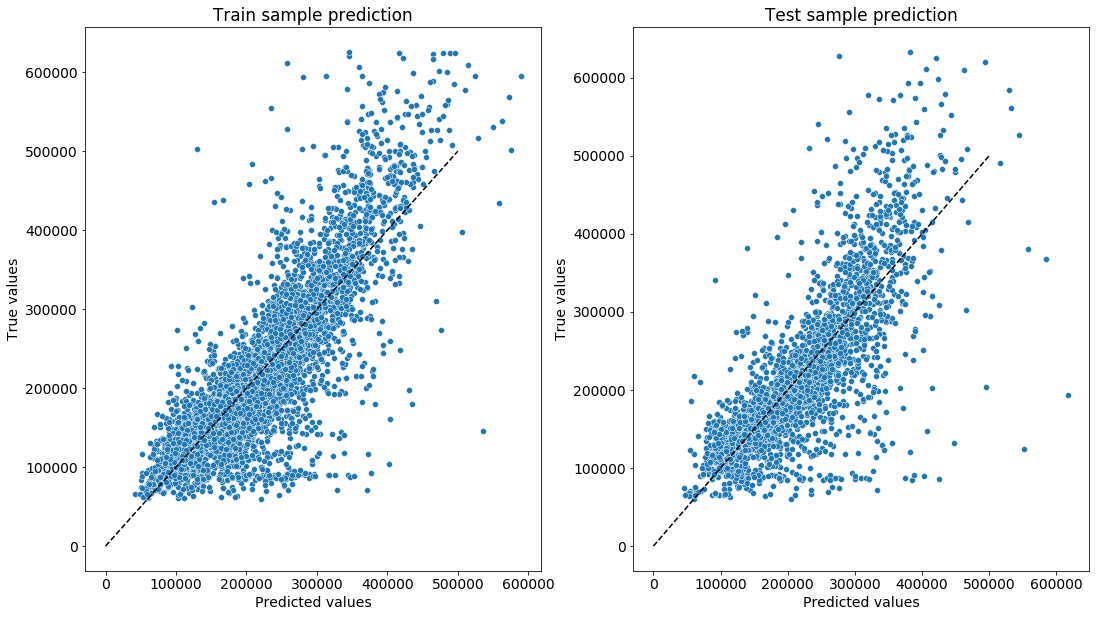

In [91]:
y_train_preds = lr_model.predict(X_train)
y_valid_preds = lr_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [92]:
#rf_model = RandomForestRegressor(max_depth=12, n_estimators=500, n_jobs=-1, random_state=39)
rf_model = RandomForestRegressor(max_depth=3, n_estimators=100, n_jobs=-1, random_state=39)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=39, verbose=0, warm_start=False)

Train R2:	0.638
Test R2:	0.578


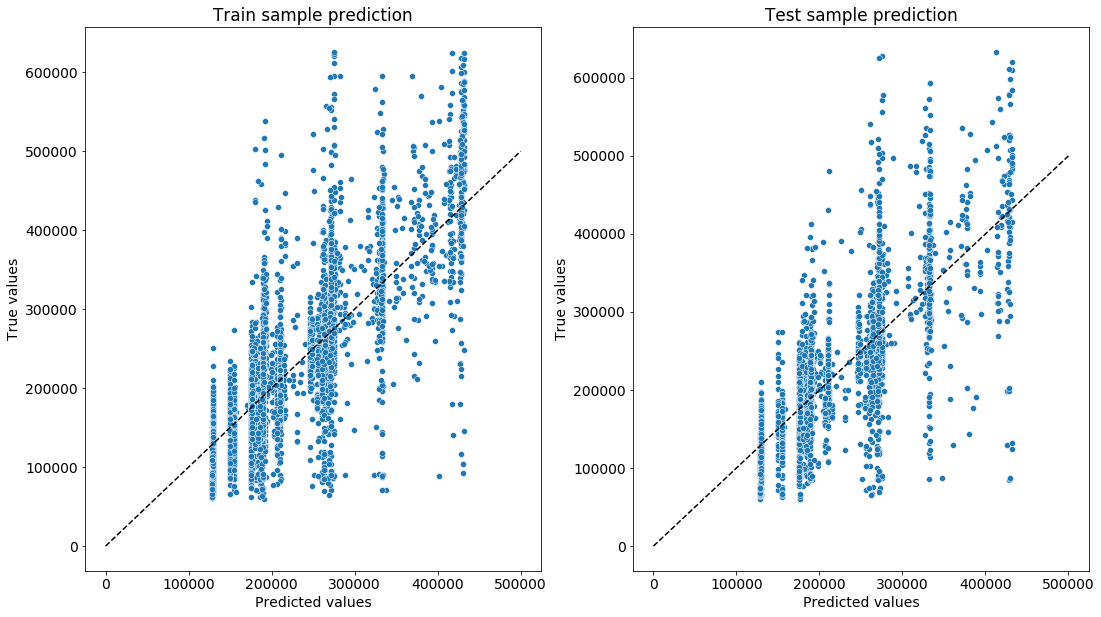

In [93]:
y_train_preds = rf_model.predict(X_train)
y_valid_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [94]:
gb_model = GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=21)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=21,
             subsample=1.0, verbose=0, warm_start=False)

Train R2:	0.789
Test R2:	0.668


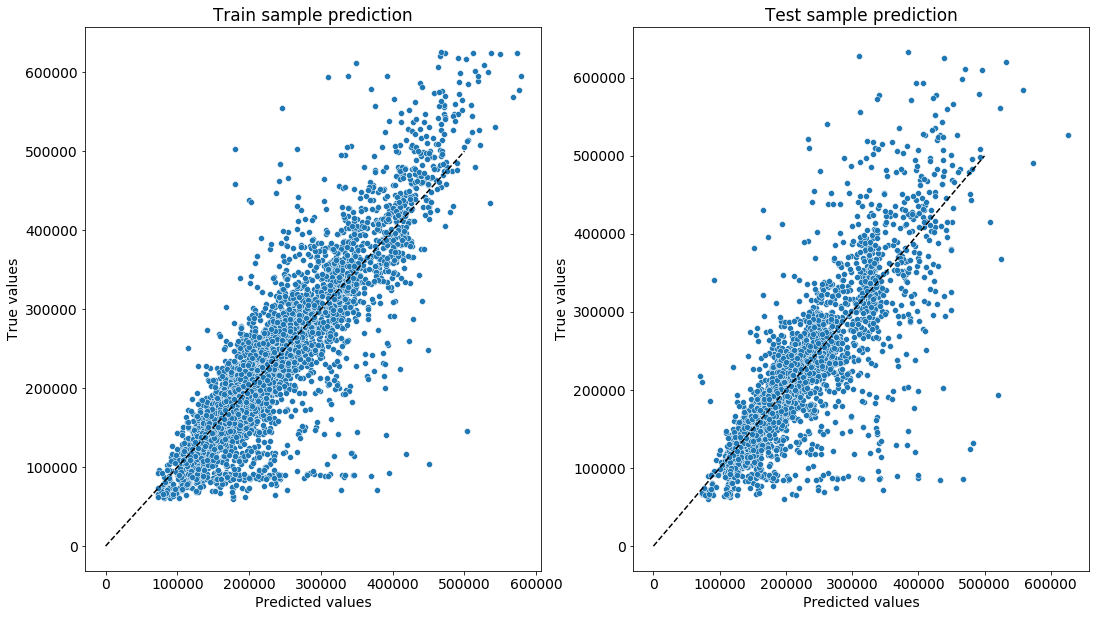

In [95]:
y_train_preds = gb_model.predict(X_train)
y_valid_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [96]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,Square,0.194005
20,med_price_per_sqm_in_dr,0.191182
8,HouseYear,0.108588
5,KitchenSquare,0.072447
13,Healthcare_1,0.069561
7,HouseFloor,0.064162
4,LifeSquare,0.055233
2,Rooms,0.032907
9,Ecology_1,0.032661
6,Floor,0.028916


In [113]:
df_num_features = X_train.select_dtypes(include=['float64'])
df_num_features.head(n=2)


,Rooms,Square,LifeSquare,HouseFloor,Ecology_1,Healthcare_1,med_price_per_sqm_in_dr
0,1.0,39.45819,21.630224,17.0,0.0509,30.0,3668.139569
1,1.0,57.08864,23.298211,30.0,0.0000,2672.0,4895.230507


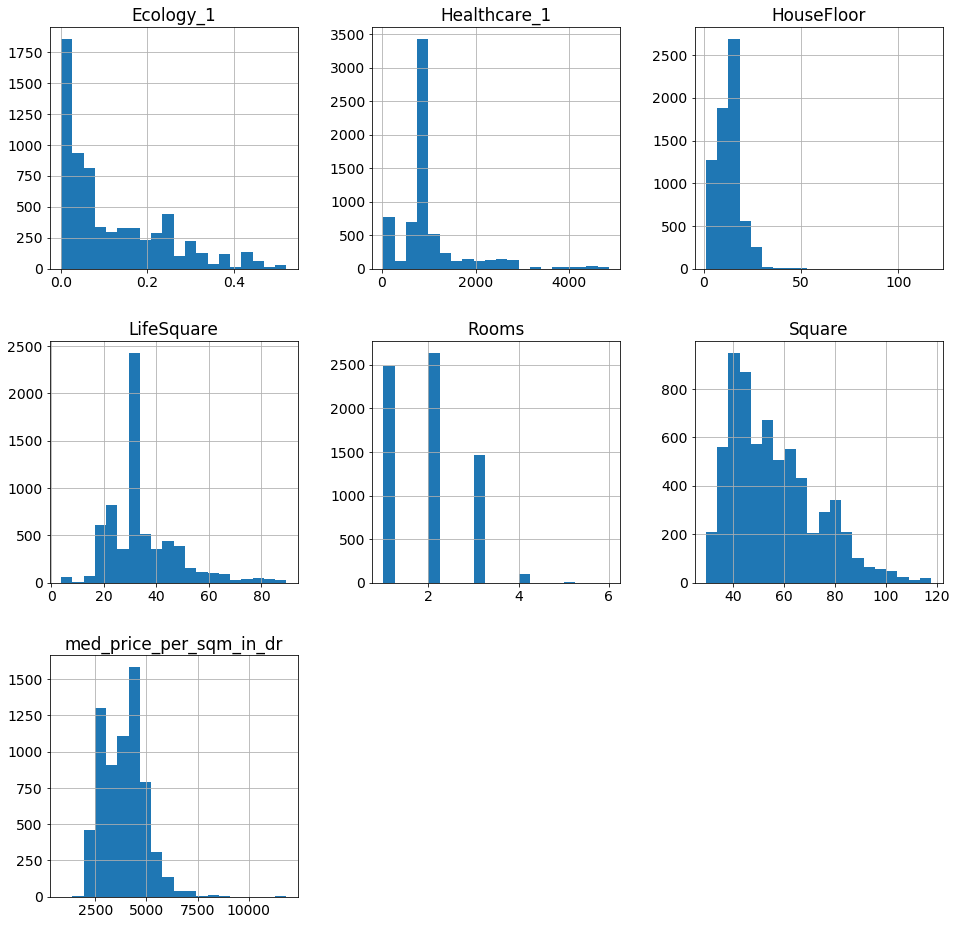

In [114]:
df_num_features.hist(figsize=(16,16), bins=20, grid =True);

In [97]:
ls_model = LassoCV()
ls_model.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

Train R2:	0.69
Test R2:	0.585


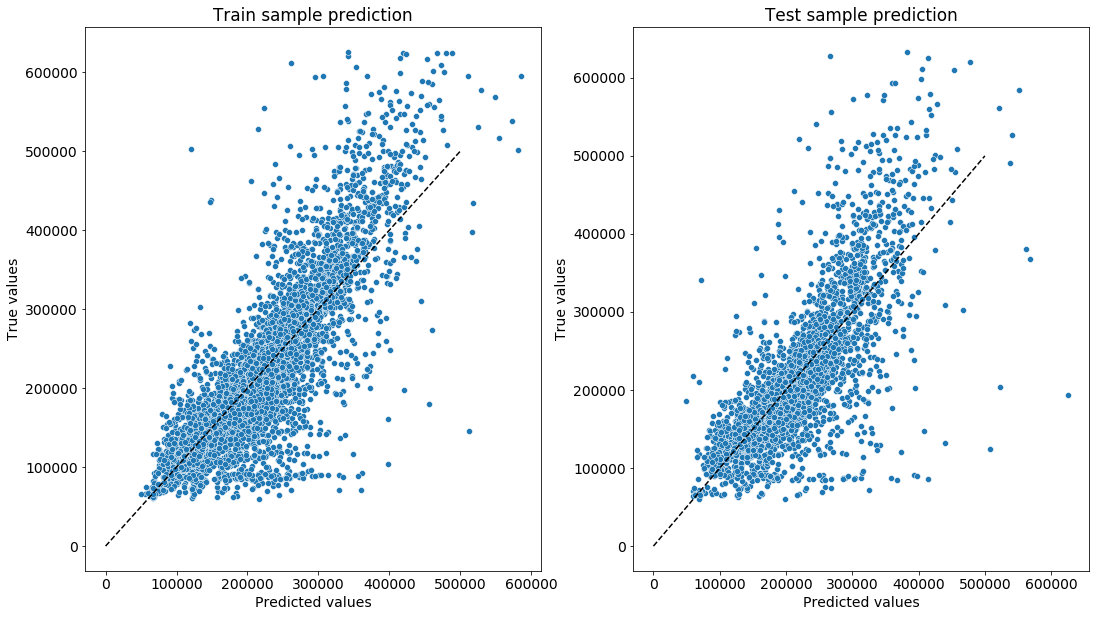

In [98]:
y_train_preds = ls_model.predict(X_train)
y_valid_preds = ls_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

## Тестовая выборка

In [99]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [100]:
valid_fix(test_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,900.0,0,0,B
1,15856,74,2.0,69.263183,32.925087,3.0,1,1.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B
2,5480,190,1.0,52.919578,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,900.0,3,3,B
4,14275,27,1.0,47.527111,43.387569,3.0,17,17.0,2017,0.072158,B,B,2,629,1,900.0,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,900.0,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,900.0,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,4,22.0,1989,0.090799,B,B,74,19083,2,900.0,5,15,B
4998,4780,62,2.0,81.305222,32.925087,3.0,4,12.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A


In [101]:
new_cat_features(test_df)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,11,2748,1,900.0,0,0,B,1,1,1
1,15856,74,2.0,69.263183,32.925087,3.0,1,1.0,1977,0.075779,...,6,1437,3,900.0,0,2,B,1,1,1
2,5480,190,1.0,52.919578,15.948246,12.0,2,5.0,1909,0.000000,...,30,7538,87,4702.0,5,5,B,1,1,1
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,23,4583,3,900.0,3,3,B,1,1,1
4,14275,27,1.0,47.527111,43.387569,3.0,17,17.0,2017,0.072158,...,2,629,1,900.0,0,0,A,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,...,36,5992,0,900.0,1,1,B,1,1,1
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,...,1,264,0,900.0,0,1,B,1,1,1
4997,5783,12,3.0,77.842178,48.282625,9.0,4,22.0,1989,0.090799,...,74,19083,2,900.0,5,15,B,1,1,1
4998,4780,62,2.0,81.305222,32.925087,3.0,4,12.0,1977,0.072158,...,2,629,1,900.0,0,0,A,1,1,0


In [102]:
test_df.drop(['Ecology_2', 'Ecology_3', 'Shops_2'], axis=1, inplace = True)

In [103]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,11,2748,1,900.0,0,0,1,1,1
1,15856,74,2.0,69.263183,32.925087,3.0,1,1.0,1977,0.075779,6,1437,3,900.0,0,2,1,1,1
2,5480,190,1.0,52.919578,15.948246,12.0,2,5.0,1909,0.000000,30,7538,87,4702.0,5,5,1,1,1
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,23,4583,3,900.0,3,3,1,1,1
4,14275,27,1.0,47.527111,43.387569,3.0,17,17.0,2017,0.072158,2,629,1,900.0,0,0,1,1,0


In [104]:
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [105]:
district_size_t = test_df['DistrictId'].value_counts().reset_index()\
                          .rename(columns={'index':'DistrictId','DistrictId':'DistrictSize'})

In [106]:
test_df = test_df.merge(district_size_t, on=['DistrictId'], how='left')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,11,2748,1,900.0,0,0,1,1,1,91
1,15856,74,2.0,69.263183,32.925087,3.0,1,1.0,1977,0.075779,6,1437,3,900.0,0,2,1,1,1,61
2,5480,190,1.0,52.919578,15.948246,12.0,2,5.0,1909,0.000000,30,7538,87,4702.0,5,5,1,1,1,2
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,23,4583,3,900.0,3,3,1,1,1,49
4,14275,27,1.0,47.527111,43.387569,3.0,17,17.0,2017,0.072158,2,629,1,900.0,0,0,1,1,0,391


In [107]:
test_df = test_df.merge(info_by_district_id, on=['DistrictId', 'Rooms'], how='left')

test_df['med_price_per_sqm_in_dr'] = test_df['med_price_per_sqm_in_dr'].fillna(
        test_df['med_price_per_sqm_in_dr'].mean())

test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,med_price_per_sqm_in_dr
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,2748,1,900.0,0,0,1,1,1,91,2577.287068
1,15856,74,2.0,69.263183,32.925087,3.0,1,1.0,1977,0.075779,...,1437,3,900.0,0,2,1,1,1,61,3049.287530
2,5480,190,1.0,52.919578,15.948246,12.0,2,5.0,1909,0.000000,...,7538,87,4702.0,5,5,1,1,1,2,3870.803225
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,4583,3,900.0,3,3,1,1,1,49,4134.015568
4,14275,27,1.0,47.527111,43.387569,3.0,17,17.0,2017,0.072158,...,629,1,900.0,0,0,1,1,0,391,2679.973486


In [108]:
test_df.shape

(5000, 21)

In [109]:
test_df.isnull().sum()

Id                         0
DistrictId                 0
Rooms                      0
Square                     0
LifeSquare                 0
KitchenSquare              0
Floor                      0
HouseFloor                 0
HouseYear                  0
Ecology_1                  0
Social_1                   0
Social_2                   0
Social_3                   0
Healthcare_1               0
Helthcare_2                0
Shops_1                    0
Ecology_2_bin              0
Ecology_3_bin              0
Shops_2_bin                0
DistrictSize               0
med_price_per_sqm_in_dr    0
dtype: int64

In [110]:
X_train.shape

(6700, 21)

In [111]:
gb_model = GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=21)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=21,
             subsample=1.0, verbose=0, warm_start=False)

In [112]:
test_id = test_df["Id"]
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Price"] = gb_model.predict(test_df)
assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

#pred_df.to_csv("./predictions_.csv", index=False)
pred_df[['Price']].round(2).to_csv('./predictions.csv', index=None)